# Weather recognition

## Data preprocessing

### Import library

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,models
import pandas as pd
import os
import cv2

2024-11-03 15:19:36.157456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 15:19:36.180302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### import train dataset

In [2]:
train_dat_dir = "./weather_image/train/"

cate_list = []
train_lable =[]
all_dataset = []

# print and load train data
for fol in os.listdir(train_dat_dir):
    folder_path = os.path.join(train_dat_dir, fol)
    cate_list.append(fol)
    print(f'{fol} : {len(os.listdir(folder_path))}')
    for img_n in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_n)
        img = Image.open(img_path).convert("RGB").resize((300,300))
        train_lable.append(fol)
        all_dataset.append(np.array(img))
print(np.array(all_dataset).shape)
print(cate_list)

sunrise : 337
cloudy : 280
shine : 232
rain : 199
(1048, 300, 300, 3)
['sunrise', 'cloudy', 'shine', 'rain']


### Data augmentation

In [3]:
original_train_data = np.copy(all_dataset)
original_train_label = np.copy(train_lable)

angles = [90, 180, 270]

for angle in angles:
    for num in range(len(original_train_data)):
        img_array = original_train_data[num]
        img = Image.fromarray(original_train_data[num])  
        rotated_img = img.rotate(angle)   
        
        train_lable.append(original_train_label[num])
        all_dataset.append(np.array(rotated_img))

In [4]:
all_dataset = np.array(all_dataset)
train_lable = np.array(train_lable)

print(all_dataset.shape)   
print(train_lable.shape)

# change the list of categories to fit hw command
cate_list[0], cate_list[1] = cate_list[1], cate_list[0]
cate_list[1], cate_list[3] = cate_list[3], cate_list[1]
print(cate_list)

(4192, 300, 300, 3)
(4192,)
['cloudy', 'rain', 'shine', 'sunrise']


### Import test dataset

In [5]:
test_data_dir = "./weather_image/test/"
test_dataset = []

print(f'test : {len(os.listdir(test_data_dir))}')
test_images = sorted(os.listdir(test_data_dir), key=lambda x: int(os.path.splitext(x)[0]))
# print(test_images)
for img_n in test_images:
    img_path = os.path.join(test_data_dir, img_n)
    img = Image.open(img_path).convert("RGB").resize((300,300))
    test_dataset.append(np.array(img))
test_dataset = np.array(test_dataset)
print(test_dataset.shape)

test : 75
(75, 300, 300, 3)


### One-hot encoding

In [6]:
label_to_index = {name: index for index, name in enumerate(cate_list)}
train_label_int = np.array([label_to_index[label] for label in train_lable])
all_label_onehot = tf.keras.utils.to_categorical(train_label_int, num_classes=len(cate_list))
print(label_to_index)
print(all_label_onehot.shape)

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}
(4192, 4)


### Reshape

In [7]:
all_dataset = all_dataset / 255.0
test_dataset = test_dataset / 255.0

### Shuffle and create validation dataset

In [8]:
validation_size = 0.1
print(all_dataset.shape)
# Calculate the sizes for training and validation sets
val_size = int(validation_size * len(all_dataset))
train_size = len(all_dataset) - val_size

# Shuffle the indices
indices = np.arange(len(all_dataset))
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)

# Split the dataset into training and validation sets based on shuffled indices
train_indices = indices[val_size:]  # Indices for training set
val_indices = indices[:val_size]      # Indices for validation set
print(train_indices.shape)
print(val_indices.shape)
# # Create training and validation datasets from NumPy arrays
train_dataset = all_dataset[train_indices]
train_label_onehot = all_label_onehot[train_indices]
val_dataset = all_dataset[val_indices]
val_label = all_label_onehot[val_indices]  

(4192, 300, 300, 3)
(3773,)
(419,)


## Build model

In [9]:
# print(f'Tensorflow version : {tf.__version__}')
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(f"GPUs Available: {gpus}")
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print("use cuda")
#     except RuntimeError as e:
#         print(e)
# else:
#     print("No gpu can be use")

# if gpus:
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])  # Set to 4GB
#         print("Limited GPU memory to 4GB")
#     except RuntimeError as e:
#         print(e)



### Model structure

In [10]:
cnn = models.Sequential(name = "CNN_model")
## convolution 
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'
                      , padding='same', input_shape=(300, 300, 3), name="conv2d_00"))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'
                      , padding='same', name="conv2d_02"))
cnn.add(layers.MaxPooling2D((2, 2), name="max_pooling2d_01"))
cnn.add(layers.Dropout(0.1, name="dropout_01")) 
## convolution
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'
                      , padding='same', name="conv2d_03"))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'
                      , padding='same', name="conv2d_05"))
cnn.add(layers.MaxPooling2D((2, 2), name="max_pooling2d_02"))
cnn.add(layers.Dropout(0.2, name="dropout_02")) 
## convolution
# cnn.add(layers.Conv2D(128, (3, 3), activation='relu'
#                       , padding='same', name="conv2d_06"))
# cnn.add(layers.Conv2D(128, (3, 3), activation='relu'
#                       , padding='same', name="conv2d_07"))
# cnn.add(layers.MaxPooling2D((2, 2), name="max_pooling2d_03"))
# cnn.add(layers.Dropout(0.2, name="dropout_03")) 
# flatten
cnn.add(layers.Flatten(name = "flatten"))
## 
# cnn.add(layers.Dense(128, activation='relu', name='Dense_3'))
# cnn.add(layers.Dropout(0.3, name="dropout_04"))
cnn.add(layers.Dense(64, activation= 'relu', name = 'Dense_1'))
cnn.add(layers.Dropout(0.3, name="dropout_05")) 
cnn.add(layers.Dense(32, activation= 'relu', name = 'Dense_2'))
cnn.add(layers.Dropout(0.3, name="dropout_06")) 
cnn.add(layers.Dense(4, activation= 'softmax', name = 'Output'))

cnn.summary()

/home/brian/miniconda3/envs/vision_hw/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_00 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_02 (Conv2D)              │ (None, 300, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_01 (MaxPooling2D) │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_01 (Dropout)            │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_03 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_05 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_02 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_02 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │    23,040,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_05 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_06 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,107,844 (88.15 MB)

 Trainable params: 23,107,844 (88.15 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False) 
cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy', 
            metrics=['accuracy'])     

/home/brian/miniconda3/envs/vision_hw/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [12]:
history = cnn.fit(train_dataset,
                train_label_onehot,        
                epochs=20,
                batch_size=32,
                validation_data = (val_dataset,val_label),
                shuffle=True)  

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.5122 - loss: 1.6297 - val_accuracy: 0.7900 - val_loss: 0.6180
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.6934 - loss: 0.6731 - val_accuracy: 0.7757 - val_loss: 0.5225
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7442 - loss: 0.5619 - val_accuracy: 0.8329 - val_loss: 0.4129
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7996 - loss: 0.5115 - val_accuracy: 0.8258 - val_loss: 0.4417
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8329 - loss: 0.4685 - val_accuracy: 0.8902 - val_loss: 0.3056
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8674 - loss: 0.3869 - val_accuracy: 0.8783 - val_loss: 0.3481
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8780 - loss: 0.3413 - val_accuracy: 0.8878 - val_loss: 0.3995
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8819 - loss: 0.3372 - val_accu

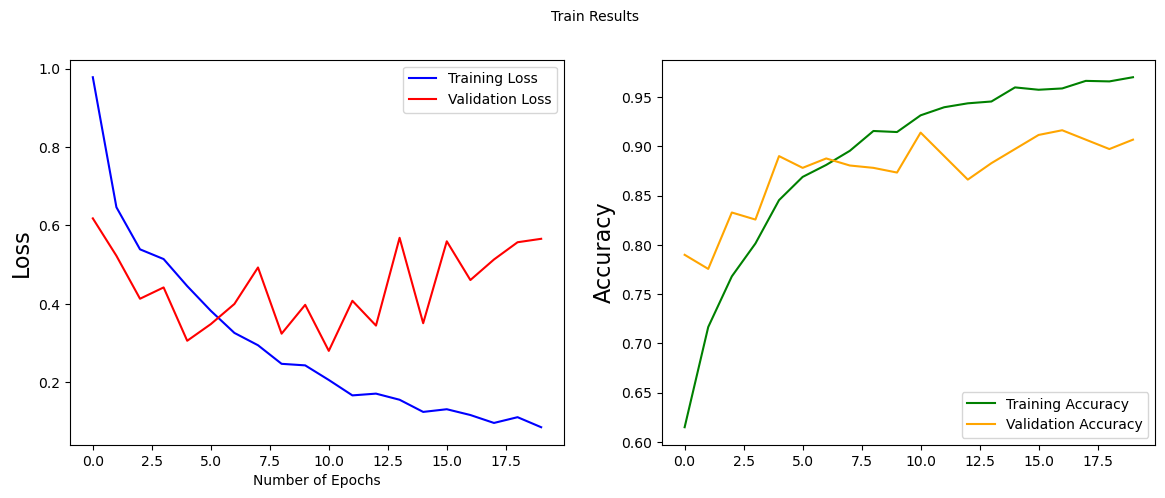

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step


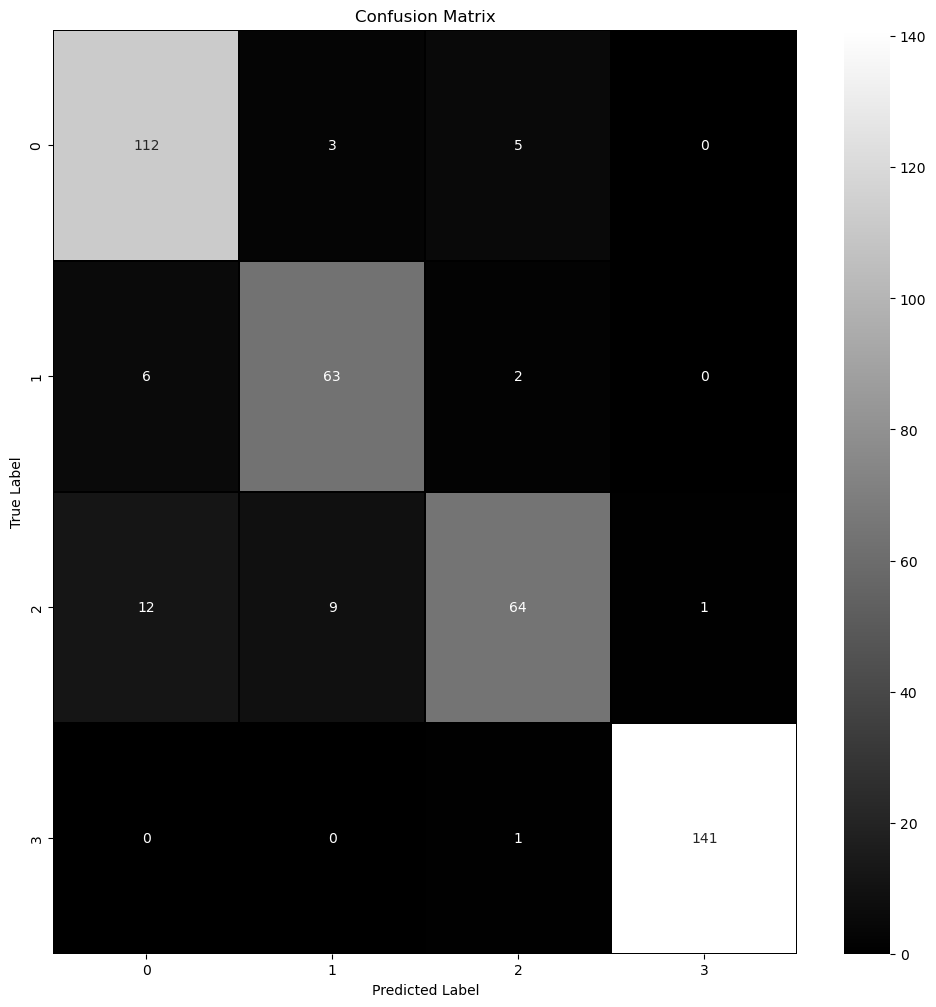

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


Y_pred = cnn.predict(val_dataset)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(val_label, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
prediction =[]
print(test_dataset.shape)
for img in test_dataset:
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    predict = cnn.predict(img)
    prediction.append(predict)
predicts =np.array(prediction)
predict_indices = np.argmax(predicts, axis=-1)

print(predict_indices)

(75, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

In [20]:

test_label=pd.DataFrame()
test_label['image_id']=test_images
test_label['labels']=predict_indices
test_label=test_label.sort_values(by='image_id')
test_label.to_csv('./weather_image/predict_label.csv',index=False) #結果轉csv檔